In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


In [2]:
btcCSV = pd.read_csv('datasets/coin_Bitcoin.csv')
btcCSV

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [3]:
df = btcCSV
scaler = MinMaxScaler()
scale_cols = ['High', 'Low', 'Open', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,High,Low,Open,Close,Volume
0,0.001126,0.001102,0.001039,0.001200,0.000000
1,0.001117,0.001103,0.001190,0.001112,0.000000
2,0.001008,0.000679,0.001111,0.000765,0.000000
3,0.000788,0.000431,0.000754,0.000580,0.000000
4,0.000518,0.000218,0.000595,0.000462,0.000000
...,...,...,...,...,...
2986,0.522701,0.526285,0.527633,0.533280,0.110349
2987,0.537668,0.536455,0.532437,0.545442,0.069476
2988,0.553539,0.552447,0.545220,0.555203,0.071016
2989,0.543457,0.533413,0.554971,0.530899,0.076137


In [4]:
TEST_SIZE = 1000
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [5]:
feature_cols = ['High', 'Low', 'Open', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols].values
train_label = train[label_cols].values
train_feature = train_feature.reshape([*train_feature.shape, -1])

test_feature = test[feature_cols].values
test_label = test[label_cols].values
test_feature = test_feature.reshape([*test_feature.shape, -1])


# train, validation set
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)


print(x_train.shape, x_valid.shape)
# (1592, 4, 1) (399, 4, 1)

# # test dataset
# test_feature, test_label = make_dataset(test_feature, test_label, 20)
print(test_feature.shape, test_label.shape)
# (1000, 4, 1) (1000, 1)


(1592, 4, 1) (399, 4, 1)
(1000, 4, 1) (1000, 1)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

2023-03-06 00:20:30.030366: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 00:20:30.030845: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [7]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=20)
filename = ('tmp_checkpoint1.h5')

# filename = os.path.join(model_path, 'tmp_checkpoint1.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=400, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Train on 1592 samples, validate on 399 samples
Epoch 1/400
1408/1592 [=========================>....] - ETA: 0s - loss: 0.0020
Epoch 00001: val_loss improved from inf to 0.00124, saving model to tmp_checkpoint1.h5
1592/1592 [==============================] - 2s 1ms/sample - loss: 0.0019 - val_loss: 0.0012
Epoch 2/400
1392/1592 [=========================>....] - ETA: 0s - loss: 4.3716e-04
Epoch 00002: val_loss improved from 0.00124 to 0.00001, saving model to tmp_checkpoint1.h5
1592/1592 [==============================] - 0s 306us/sample - loss: 3.8294e-04 - val_loss: 1.2269e-05
Epoch 3/400
1456/1592 [==========================>...] - ETA: 0s - loss: 6.7286e-06
Epoch 00003: val_loss improved from 0.00001 to 0.00001, saving model to tmp_checkpoint1.h5
1592/1592 [==============================] - 0s 300us/sample - loss: 7.8506e-06 - val_loss: 7.5274e-06
Epoch 4/400
1472/1592 [==========================>...] - ETA: 0s - loss: 7.2287e-06
Epoch 00004: val_loss improved from 0.00001 to 0.0000

Epoch 34/400
1568/1592 [============================>.] - ETA: 0s - loss: 7.4423e-06
Epoch 00034: val_loss did not improve from 0.00001
1592/1592 [==============================] - 0s 306us/sample - loss: 7.3556e-06 - val_loss: 6.6879e-06
Epoch 35/400
1584/1592 [============================>.] - ETA: 0s - loss: 7.0734e-06
Epoch 00035: val_loss did not improve from 0.00001
1592/1592 [==============================] - 1s 340us/sample - loss: 7.0438e-06 - val_loss: 7.3348e-06
Epoch 36/400
1504/1592 [===========================>..] - ETA: 0s - loss: 6.2041e-06
Epoch 00036: val_loss did not improve from 0.00001
1592/1592 [==============================] - 0s 308us/sample - loss: 6.2891e-06 - val_loss: 6.4904e-06
Epoch 37/400
1584/1592 [============================>.] - ETA: 0s - loss: 6.1526e-06
Epoch 00037: val_loss did not improve from 0.00001
1592/1592 [==============================] - 0s 299us/sample - loss: 6.1375e-06 - val_loss: 7.7814e-06
Epoch 38/400
1584/1592 [====================

Epoch 68/400
1552/1592 [============================>.] - ETA: 0s - loss: 6.1546e-06
Epoch 00068: val_loss did not improve from 0.00001
1592/1592 [==============================] - 0s 308us/sample - loss: 6.1661e-06 - val_loss: 6.3592e-06
Epoch 69/400
1440/1592 [==========================>...] - ETA: 0s - loss: 5.2814e-06
Epoch 00069: val_loss did not improve from 0.00001
1592/1592 [==============================] - 0s 291us/sample - loss: 6.3411e-06 - val_loss: 1.2121e-05
Epoch 70/400
1504/1592 [===========================>..] - ETA: 0s - loss: 6.1262e-06
Epoch 00070: val_loss did not improve from 0.00001
1592/1592 [==============================] - 1s 362us/sample - loss: 7.0132e-06 - val_loss: 7.4268e-06
Epoch 71/400
1584/1592 [============================>.] - ETA: 0s - loss: 5.8617e-06
Epoch 00071: val_loss did not improve from 0.00001
1592/1592 [==============================] - 0s 309us/sample - loss: 5.8592e-06 - val_loss: 6.3288e-06
Epoch 72/400
1568/1592 [====================

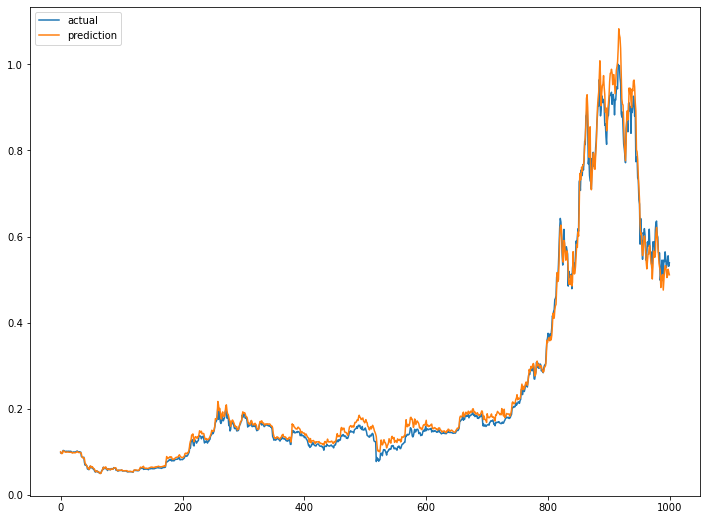

In [8]:
plt.figure(figsize=(12, 9))

pred = model.predict(test_feature)
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()